In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
int = np.vectorize(int)

In [2]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
betx = 1.9065054393933862
alfx = 1.408226172730429
Nturn = np.array([128,256,512,1024])
Nskip = int(Nturn/64)
index = 2064

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [3]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode, nSample = arr.shape
    diff = np.abs(ref-arr)
    for i in range(nMode):
        for j in range(nSample):
            if (diff[i,j]>0.5):
                diff[i,j] = 1.0 - diff[i,j]
    return np.min(diff,0)

In [4]:
indexTBT,TBTdata = impact.readTBT(index,ke,mass,freq)
indexTBT,TBTdata_Inv = impact.readTBT_integral(index)
turn,dim,npt=TBTdata.shape

In [5]:
X = TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:])
Y = TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:])
DiffLog = np.zeros([len(Nturn),3,npt])
iMax = np.zeros([len(Nturn),3],dtype=np.int)
iMin = np.zeros([len(Nturn),3],dtype=np.int)
tuneXbefore= np.zeros([len(Nturn),1,npt])
tuneXafter = np.zeros([3,npt])
tuneYbefore= np.zeros([len(Nturn),1,npt])
tuneYafter = np.zeros([3,npt])
for n in range(len(Nturn)):
    nturn = Nturn[n]
    nskip = Nskip[n]
    for i in range(npt):
        tuneXbefore[n,:,i],amp,dummy = impact.util.naff(1,X[:nturn,i],window_id=1)
        tuneXafter [:,i],amp,dummy = impact.util.naff(3,X[nturn+nskip:,i],window_id=1)
        tuneYbefore[n,:,i],amp,dummy = impact.util.naff(1,Y[:nturn,i],window_id=1)
        tuneYafter [:,i],amp,dummy = impact.util.naff(3,Y[nturn+nskip:,i],window_id=1)
    Xdiff = getClosestDiff(tuneXbefore[n,:,:],tuneXafter)
    Ydiff = getClosestDiff(tuneYbefore[n,:,:],tuneYafter)
    Adiff = np.sqrt(Xdiff**2 +Ydiff**2)
    AdiffLog = np.log10(Adiff+1.0e-6)
    XdiffLog = np.log10(Xdiff+1.0e-6)
    YdiffLog = np.log10(Ydiff+1.0e-6)
    DiffLog[n,:,:] = AdiffLog,XdiffLog,YdiffLog
    iMax[n,:] = np.argmax(Adiff),np.argmax(Xdiff),np.argmax(Ydiff)
    iMin[n,:] = np.argmin(Adiff),np.argmin(Xdiff),np.argmin(Ydiff)

# plot

### FFT

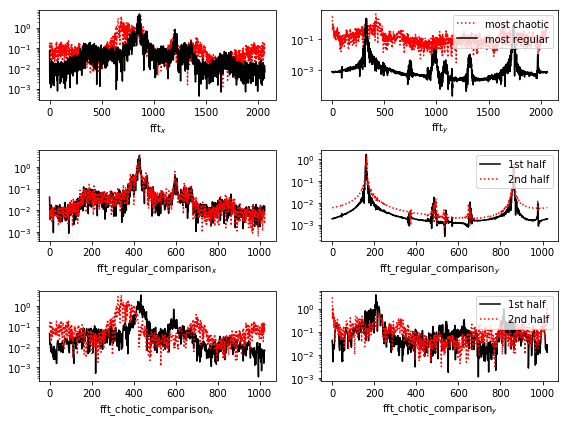

In [6]:
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[:,iMax[-1,1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[:,iMin[-1,1]])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[:,iMax[-1,2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[:,iMin[-1,2]])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[:nturn,iMin[-1,1]])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nturn+nskip:,iMin[-1,1]])),'r:')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[:nturn,iMin[-1,2]])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nturn+nskip:,iMin[-1,2]])),'r:')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[:nturn,iMax[-1,1]])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nturn+nskip:,iMax[-1,1]])),'r:')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[:nturn,iMax[-1,2]])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nturn+nskip:,iMax[-1,2]])),'r:')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.png',dpi=180)
# plt.close()

### tune plot

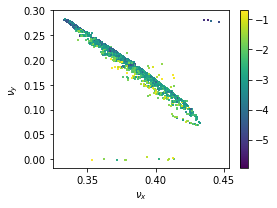

In [7]:
plt.figure(figsize=[4,3])
f1=plt.scatter(tuneXbefore[-1,0,:],tuneYbefore[-1,0,:],c=DiffLog[-1,0,:],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.tune.A.png',dpi=180)
# plt.close()

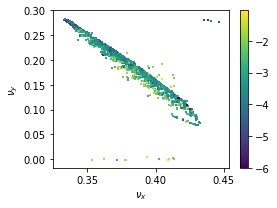

In [8]:
plt.figure(figsize=[4,3])
f1=plt.scatter(tuneXbefore[-1,0,:],tuneYbefore[-1,0,:],c=DiffLog[-1,1,:],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.tune.X.png',dpi=180)

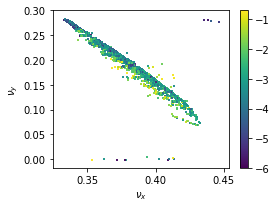

In [9]:
plt.figure(figsize=[4,3])
f1=plt.scatter(tuneXbefore[-1,0,:],tuneYbefore[-1,0,:],c=DiffLog[-1,2,:],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.tune.Y.png',dpi=180)

### Poincare

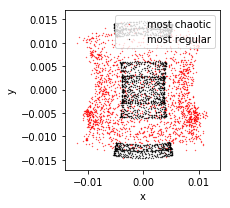

In [10]:
plt.figure(figsize=[3.3,3])
plt.scatter(TBTdata[:,0,iMax[-1,0]],TBTdata[:,2,iMax[-1,0]],c='r',s=0.1)
plt.scatter(TBTdata[:,0,iMin[-1,0]],TBTdata[:,2,iMin[-1,0]],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.A.png',dpi=180)

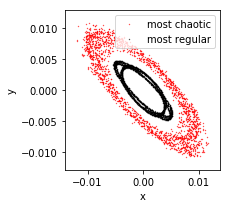

In [11]:
plt.figure(figsize=[3.3,3])
plt.scatter(TBTdata[:,0,iMax[-1,0]],TBTdata[:,1,iMax[-1,0]],c='r',s=0.1)
plt.scatter(TBTdata[:,0,iMin[-1,0]],TBTdata[:,1,iMin[-1,0]],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.X.png',dpi=180)

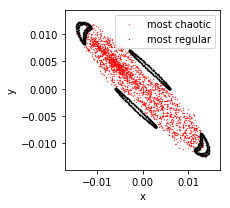

In [12]:
plt.figure(figsize=[3.3,3])
plt.scatter(TBTdata[:,2,iMax[-1,0]],TBTdata[:,3,iMax[-1,0]],c='r',s=0.1)
plt.scatter(TBTdata[:,2,iMin[-1,0]],TBTdata[:,3,iMin[-1,0]],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.Y.png',dpi=180)

### Dynamic Aperture

In [13]:
xmax = np.max([TBTdata[0,0,:],TBTdata[0,2,:]])
for n in range(len(Nturn)):
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=DiffLog[n,0,:],s=1.6,marker='s')
    plt.scatter(TBTdata[0,0,iMax[n,0]],TBTdata[0,2,iMax[n,0]],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.A.'+str(nturn)+'.png',dpi=180)
    plt.close()

In [14]:
for n in range(len(Nturn)):
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=DiffLog[n,1,:],s=1.6,marker='s')
    plt.scatter(TBTdata[0,0,iMax[n,1]],TBTdata[0,2,iMax[n,1]],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.X.'+str(nturn)+'.png',dpi=180)
    plt.close()

In [15]:
for n in range(len(Nturn)):
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=DiffLog[n,2,:],s=1.6,marker='s')
    plt.scatter(TBTdata[0,0,iMax[n,2]],TBTdata[0,2,iMax[n,2]],c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.Y.'+str(nturn)+'.png',dpi=180)
    plt.close()

### Invariants

In [19]:
for n in range(len(Nturn)):
    plt.figure(figsize=[4,3])
    f1=plt.scatter(TBTdata_Inv[0,0,:],TBTdata_Inv[0,1,:],c=DiffLog[n,0,:],s=3.0,marker='s',alpha=0.5)
    plt.scatter(TBTdata_Inv[0,0,iMax[n,0]],TBTdata_Inv[0,1,iMax[n,0]],c='r',s=77,marker='x')
    plt.xlim(0,1.15)
    plt.ylim(0,2.3)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    plt.colorbar(f1)
    plt.tight_layout()
    plt.savefig('FMA.Int.Log.A.'+str(nturn)+'.png',dpi=180)
    plt.close()